# Data Pre-Processing

In [ ]:
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning

# ignoring warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# importing data
df = pd.read_csv('SWFL_Properties_Cleaned.csv')

# converting string values to int
numeric_cols = ['price', 'year', 'baths', 'sqft', 'Number of Ammenities',
                'Living Area', 'Total Area', 'Total Floors',
                'Garage Spaces', 'Bedrooms']

for col in numeric_cols:
  df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True).astype(int)

# converting 'Community Type' to boolean
df['Community Type'] = [1 if i=="Gated" else 0 for i in df['Community Type']]

# removing 'sqft' feature
df = df.drop(columns=['sqft'])

  # Verify all correct type
  # for col in df.columns:
  #   print(f'Name: {col} Type: {type(df[col][0])}')

df.head()

,ID,price,year,baths,Community Type,Number of Ammenities,Living Area,Total Area,Total Floors,Garage Spaces,Bedrooms
0,1,899000,2022,3,1,8,2266,2882,2,2,3
1,2,699995,2024,3,1,4,2242,2940,2,2,6
2,3,699000,2022,3,1,8,2243,2940,2,2,4
3,4,595000,2022,2,1,4,1569,1965,1,2,2
4,5,599995,2024,2,1,6,1643,2261,1,2,3


## Initial Visualizations

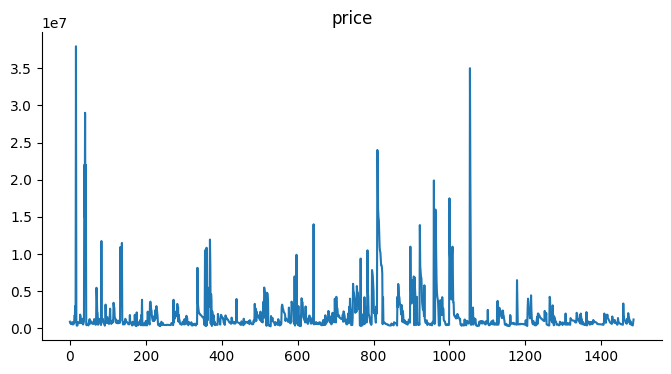

In [ ]:
# @title price

from matplotlib import pyplot as plt
df['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

# Functions

In [ ]:
# Bucket Function #1: Break price up into various counts of buckets
def create_buckets(df, col, num_buckets):
  """
  Creates buckets based on values in a given column in a dataframe.
  Args:
    df: dataframe
    col: column to create buckets from
    num_buckets: number of buckets to create
  Returns:
    df: dataframe with buckets column added
  """

  dfc = df.copy()

  dfc = dfc.sort_values([col]).reset_index(drop=True)

  bucket_size = len(dfc) // num_buckets

  dfc['bucket'] = num_buckets - 1

  for i in range(num_buckets):
    start_index = i * bucket_size
    end_index = start_index + bucket_size

    for j in range(start_index, end_index):
      dfc.at[j, 'bucket'] = i

  return dfc

# Function to print bucket ranges
def print_bucket_ranges(df):
  """
  Prints the price range of each bucket in a dataframe.
  Args:
    df: dataframe
  Returns:
    None
  """
  df_sorted = df.sort_values('bucket').reset_index(drop=True)
  for bucket in df_sorted['bucket'].unique():
    print(f'Bucket Name: {bucket}')
    max_price_in_bucket = df_sorted[df_sorted['bucket'] == bucket]['price'].max()
    min_price_in_bucket = df_sorted[df_sorted['bucket'] == bucket]['price'].min()
    print(f'Price Range: {min_price_in_bucket} - {max_price_in_bucket}')
    print()

def create_log_reg_model(X, y):
  """
  Creates a logistic regression model.
  Args:
    X: features
    y: target
  Returns:
    model: logistic regression model
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LogisticRegression(max_iter=1000)

  model.fit(X_train, y_train)

  return model

def evaluate_log_reg_model(model, X, y):
  """
  Evaluates a logistic regression model.
  Args:
    model: logistic regression model
    X: features
    y: target
  Returns:
    None
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  y_pred = model.predict(X_test)

  accuracy_lr_b1 = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy_lr_b1:.2f}")
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

# Models without Feature Engineering

In [ ]:
# imports
from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, root_mean_squared_log_error, r2_score, mean_absolute_percentage_error, accuracy_score, classification_report, mean_absolute_error, confusion_matrix, precision_recall_fscore_support, roc_auc_score

## Regression Models

In [ ]:
# Linear Regression Model w/o Feature Engineering
X = df.drop(columns=['ID', 'price'])
y = df['price']

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creating and fitting model
lin_reg_model_wo = LinearRegression()
lin_reg_model_wo.fit(X_train, y_train)

# predictions
y_pred_lir = lin_reg_model_wo.predict(X_test)
y_pred_lir = np.clip(y_pred_lir, 0, None)  # Clip predictions to be >= 0

# metrics
r2_lr_wo = r2_score(y_test, y_pred_lir)
rmsle_lr_wo = root_mean_squared_log_error(y_test, y_pred_lir)
mse_lr_wo = mean_squared_error(y_test, y_pred_lir)
mae_lr_wo = mean_absolute_error(y_test, y_pred_lir)

# printing metrics
print("Intercept:", lin_reg_model_wo.intercept_)
print("Coefficients:", lin_reg_model_wo.coef_)
print(f"R^2 Score: {r2_lr_wo}")
print(f"Root Mean Squared Log Error: {rmsle_lr_wo}")
print(f"Mean Squared Error: {mse_lr_wo}")
print(f"Mean Absolute Error: {mae_lr_wo}")

Intercept: -29430601.628018532
Coefficients: [ 1.40937185e+04 -7.25062370e+04 -1.27384282e+06 -1.11972088e+04
  2.22888445e+03 -2.64476970e+02 -4.83383571e+04  3.50108070e+05
 -3.76888529e+05]
R^2 Score: 0.6582647232418146
Root Mean Squared Log Error: 5.254392143080956
Mean Squared Error: 2251636551027.5283
Mean Absolute Error: 833327.3687873358


In [ ]:
# Random Forest Regression w/o Feature Egineering
X = df.drop(columns=['ID', 'price'])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rfr_wo = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_wo.fit(X_train, y_train)

y_pred_rfr_wo = rfr_wo.predict(X_test)

mae_rfr_wo = mean_absolute_error(y_test, y_pred_rfr_wo)
mse_rfr_wo = np.sqrt(mean_squared_error(y_test, y_pred_rfr_wo))
rmsle_rfr_wo = root_mean_squared_log_error(y_test, y_pred_rfr_wo)
r2_rfr_wo = r2_score(y_test, y_pred_rfr_wo)

# Print results
print(f"R^2 Score: {r2_rfr_wo}")
print(f"Root Mean Squared Log Error: {rmsle_rfr_wo}")
print(f"Mean Squared Error: {mse_rfr_wo}")
print(f"Mean Absolute Error: {mae_rfr_wo}")

R^2 Score: 0.8669096336052807
Root Mean Squared Log Error: 0.3296902730883723
Mean Squared Error: 936434.8093855074
Mean Absolute Error: 446078.86280968355


# Feature Engineering

In [ ]:
today = datetime.date.today()
year = today.year

# Feature Engineering
df['Base Rooms'] = df['Bedrooms'] + df['baths']
df["House Age"] = year - df['year']
df['Living Area Ratio'] = df['Living Area']/df['Total Area']
df['Living Area Squared'] = df['Living Area']**2

# Models with Feature Engineering

## Regression Models

In [ ]:
# Linear Regression with Feature engineering
X = df.drop(columns=['ID', 'price'])
y = df['price']

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creating and fitting model
lin_reg_model_fe = LinearRegression()
lin_reg_model_fe.fit(X_train, y_train)

# predictions
y_pred_lir_fe = lin_reg_model_fe.predict(X_test)
y_pred_lir_fe = np.clip(y_pred_lir_fe, 0, None)  # Clip predictions to be >= 0

# metrics
r2_lr = r2_score(y_test, y_pred_lir_fe)
rmsle_lr = root_mean_squared_log_error(y_test, y_pred_lir_fe)
mse_lr = mean_squared_error(y_test, y_pred_lir_fe)
mae_lr = mean_absolute_error(y_test, y_pred_lir_fe)

# printing metrics
print("Intercept:", lin_reg_model_fe.intercept_)
print("Coefficients:", lin_reg_model_fe.coef_)
print(f"R^2 Score: {r2_lr}")
print(f"Root Mean Squared Log Error: {rmsle_lr}")
print(f"Mean Squared Error: {mse_lr}")
print(f"Mean Absolute Error: {mae_lr}")

Intercept: -12921408.764016917
Coefficients: [ 7.39510708e+03  2.17435404e+05 -1.17816809e+06 -2.66439830e+03
  1.15674641e+03 -5.51580419e+02 -2.44806739e+04  3.07244219e+05
 -2.38604312e+05 -2.11689081e+04 -7.39510708e+03 -2.17979151e+06
  1.51780418e-01]
R^2 Score: 0.6916926905302299
Root Mean Squared Log Error: 4.164307728203676
Mean Squared Error: 2031385268551.9177
Mean Absolute Error: 740438.531542297


In [ ]:
# # Feature Importance Plot #1
# # Summarize feature importance
# for i,v in enumerate(lin_reg_model_fe.coef_):
#     print(f"Feature: ", X.columns[i])
#     print('Score: %.5f\n' % (v))
# # plot feature importance
# plt.bar([x for x in range(len(lin_reg_model_fe.coef_))], lin_reg_model_fe.coef_)
# plt.show()

# # Feature Importance Plot #2
# scaler = MinMaxScaler()
# normalized_coefficients = scaler.fit_transform(lin_reg_model_fe.coef_.reshape(-1, 1)).flatten()

# df_importance = pd.DataFrame({'feature': X.columns, 'importance': normalized_coefficients})

# # Sort by absolute importance
# df_importance['abs_importance'] = df_importance['importance'].abs()
# df_importance = df_importance.sort_values('abs_importance', ascending=False).drop('abs_importance', axis=1)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.bar(df_importance['feature'], df_importance['importance'])
# plt.xlabel('Feature')
# plt.ylabel('Coefficient Value')
# plt.title('Linear Regression Feature Importance')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # Feature Importance Plot #3
# # Get Feature Importance (Absolute Coefficients)
# coefficients = np.abs(lin_reg_model_fe.coef_)
# importance = 100 * (coefficients / coefficients.sum())  # Normalize to sum to 100

# # Create a DataFrame for sorting
# feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# # Sort in descending order
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# # Plot Feature Importance
# plt.figure(figsize=(8, 5))
# plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='royalblue')
# plt.xlabel("Importance (out of 100)")
# plt.ylabel("Features")
# plt.title("Feature Importance for Linear Regression")
# plt.gca().invert_yaxis() # Highest importance on top
# plt.show()

In [ ]:
# SVM Model with Feature Engineering
X = df.drop(columns=['ID', 'price'])
y = df['price']

# standardizing data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 725)

# initializing model
model_SVR = svm.SVR()
model_SVR.fit(X_train, y_train)

# gathering predicts
y_pred_SVR = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(y_test, y_pred_SVR))

# metrics
r2_svm_reg = r2_score(y_test, y_pred_SVR)
rmsle_svm_reg = root_mean_squared_log_error(y_test, y_pred_SVR)
mse_svm_reg = mean_squared_error(y_test, y_pred_SVR)
mae_svm_reg = mean_absolute_error(y_test, y_pred_SVR)

# printing metrics
print(f"R^2 Score: {r2_svm_reg}")
print(f"Root Mean Squared Log Error: {rmsle_svm_reg}")
print(f"Mean Squared Error: {mse_svm_reg}")
print(f"Mean Absolute Error: {mae_svm_reg}")

0.5094832929687594
R^2 Score: -0.09169666962164125
Root Mean Squared Log Error: 0.9004735336599606
Mean Squared Error: 11561791602512.05
Mean Absolute Error: 1263262.2259938922


In [ ]:
# xgboost model
X = df.drop(columns=['price', 'ID'])
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=725)

xg_model = XGBRegressor()

xg_model.fit(X_train, y_train)
y_xg_pred = xg_model.predict(X_test)

# metrics
r2_xgb = r2_score(y_test, y_xg_pred)
rmsle_xgb = root_mean_squared_log_error(y_test, y_xg_pred)
mse_xgb = mean_squared_error(y_test, y_xg_pred)
mae_xgb = mean_absolute_error(y_test, y_xg_pred)

# printing metrics
print(f"R^2 Score: {r2_xgb}")
print(f"Root Mean Squared Log Error: {rmsle_xgb}")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")

R^2 Score: 0.504202127456665
Root Mean Squared Log Error: 0.34391388297080994
Mean Squared Error: 5250828206080.0
Mean Absolute Error: 647394.1875


In [ ]:
# Random Forest Regression w/ Feature Egineering
X = df[["year", "Community Type", "Total Area", "Total Floors", "Garage Spaces",
        "Base Rooms", "Living Area Ratio", "House Age", "Living Area Squared"]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
rmsle_rfr = root_mean_squared_log_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print("Mean Absolute Error (MAE):", mae_rfr)
print("Root Mean Squared Log Error (RMSLE):", rmsle_rfr)
print("Mean Squared Error (MSE):", mse_rfr)
print("R² Score:", r2_rfr)

Mean Absolute Error (MAE): 460553.4463851436
Root Mean Squared Log Error (RMSLE): 0.346727460350688
Mean Squared Error (MSE): 899434993098.3947
R² Score: 0.8634909945158735


## Classification Models

In [ ]:
# Logistic Regression With Feature Engineering and optimal number of
# quantized buckets

bucket_accuracy = {}

df_buckets = create_buckets(df, 'price', 9)
X = df_buckets.drop(columns=['ID', 'price', 'bucket'])
y = df_buckets['bucket']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating and fitting model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# predictions
y_pred_log = log_reg_model.predict(X_test)

accur_lrb2 = accuracy_score(y_test, y_pred_log)
mae_lrb2 = mean_absolute_error(y_test, y_pred_log)
precision_lrb2, recall_lrb2, f1_lrb2, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [ ]:
# Classification Model with Feature Engineering and manually defined price ranges
df['bucket'] = 9
df.loc[df['price'] < 2050000, 'bucket'] = 8
for i in range(7, -1, -1):
  df.loc[(df['price'] < (250000 + i*100000)), 'bucket'] = i

# Checking bucket distribution
frequency_counts = df['bucket'].value_counts()
print(frequency_counts)

y_labels = df.bucket
X_bucket = df.drop(columns=['price', 'bucket', 'ID'])

# standardizing data
scaler_bucket = StandardScaler().fit(X_bucket)
X_bucket = scaler_bucket.transform(X_bucket)

X_train, X_test, y_train, y_test = train_test_split(X_bucket, y_labels, test_size=0.2, random_state=42)

buckets_model = create_log_reg_model(X_train, y_train)

y_pred = buckets_model.predict(X_test)

accur_lrb1 = accuracy_score(y_test, y_pred)
mae_lrb1 = mean_absolute_error(y_test, y_pred)
precision_lrb1, recall_lrb1, f1_lrb1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

bucket
8    371
9    267
4    183
3    178
5    130
6    127
2    119
7     96
1     15
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Random Forest Classifier with Feature Engineering

df_bucket = create_buckets(df, 'price', 9)

year = today.year
df_bucket["Base Rooms"] = df_bucket["Bedrooms"] + df["baths"]
df_bucket["Living Area Ratio"] = df_bucket["Living Area"] / df["Total Area"]
df_bucket["Living Area Squared"] = df_bucket["Living Area"] ** 2
df_bucket["House Age"] = year - df_bucket['year']

y_labels = df_bucket.bucket
X_bucket = df_bucket.drop(columns=['ID', 'price', 'bucket'])

scaler_bucket = StandardScaler().fit(X_bucket)
X_bucket = scaler_bucket.transform(X_bucket)

X_bucket_train, X_bucket_test, y_labels_train, y_labels_test = train_test_split(X_bucket, y_labels, test_size=0.2, random_state=725)

rf_buckets = RandomForestClassifier(random_state=42)

rf_buckets.fit(X_bucket_train, y_labels_train)

y_labels_pred = rf_buckets.predict(X_bucket_test)

accur_rfc = accuracy_score(y_labels_test, y_labels_pred)
mae_rfc = mean_absolute_error(y_labels_test, y_labels_pred)
precision_rfc, recall_rfc, f1_rfc, _ = precision_recall_fscore_support(y_labels_test, y_labels_pred, average='weighted')

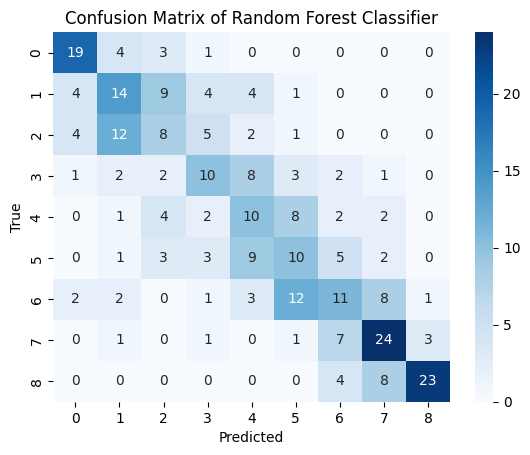

In [ ]:
cm = confusion_matrix(y_labels_test, y_labels_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.show()

# Evaluation

<Axes: >

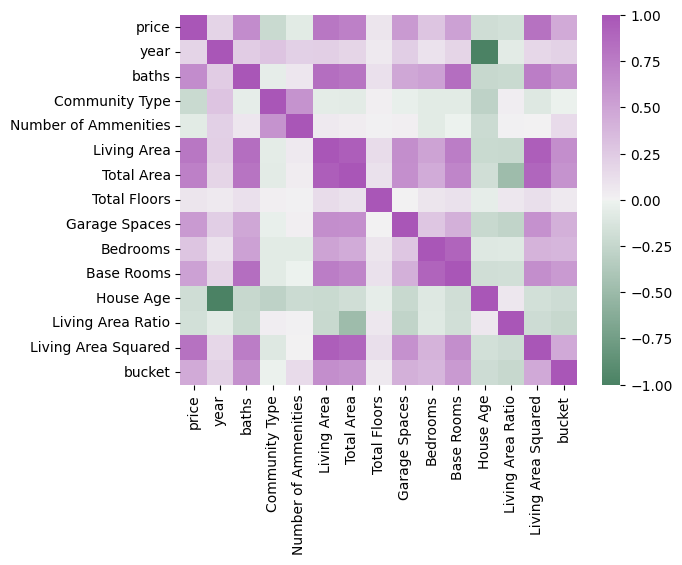

In [ ]:
pal = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(df.drop(columns=['ID']).corr(), cmap = pal)

In [23]:
# Regression Model Performance Table
regression_models = [
    "Linear Reg w/o FE",
    "Random Forest Reg w/o FE",
    "Linear Reg",
    "Random Forest Regressor",
    "XGBoost",
]
regression_metrics = ["R^2", "RMSLE", "MAE"]

# Create regression performance DataFrame with sample values
regression_data = {
    "R^2": [r2_lr_wo, r2_rfr_wo, r2_lr, r2_rfr, r2_xgb],
    "RMSLE": [rmsle_lr_wo, rmsle_rfr_wo, rmsle_lr, rmsle_rfr, rmsle_xgb],
    "MAE": [mae_lr_wo, mae_rfr_wo, mae_lr, mae_rfr, mae_xgb]
}
regression_df = pd.DataFrame(regression_data, index=regression_models)

# Define classification models and metrics
classification_models = [
    "Logistic Regression B1",
    "Logistic Regression B2",
    "Random Forest Classifier"
]
classification_metrics = ["Accuracy", "Mean Absolute Error", "Precision", "Recall", "F1"]

# Create classification performance DataFrame with sample values
classification_data = {
    "Accuracy": [accur_lrb1, accur_lrb2, accur_rfc],
    "Mean Absolute Error": [mae_lrb1, mae_lrb2, mae_rfc],
    "Precision": [precision_lrb1, precision_lrb2, precision_rfc],
    "Recall": [recall_lrb1, recall_lrb2, recall_rfc],
    "F1": [f1_lrb1, f1_lrb2, f1_rfc]
}
classification_df = pd.DataFrame(classification_data, index=classification_models)

# Display tables
print("Regression Model Performance Table:\n")
print(regression_df.to_markdown())
print("\nClassification Model Performance Table:\n")
print(classification_df.to_markdown())

Regression Model Performance Table:

|                          |      R^2 |    RMSLE |    MAE |
|:-------------------------|---------:|---------:|-------:|
| Linear Reg w/o FE        | 0.658265 | 5.25439  | 833327 |
| Random Forest Reg w/o FE | 0.86691  | 0.32969  | 446079 |
| Linear Reg               | 0.691693 | 4.16431  | 740439 |
| Random Forest Regressor  | 0.863491 | 0.346727 | 460553 |
| XGBoost                  | 0.504202 | 0.343914 | 647394 |

Classification Model Performance Table:

|                          |   Accuracy |   Mean Absolute Error |   Precision |   Recall |       F1 |
|:-------------------------|-----------:|----------------------:|------------:|---------:|---------:|
| Logistic Regression B1   |   0.496644 |              1.10067  |    0.492949 | 0.496644 | 0.462861 |
| Logistic Regression B2   |   0.40604  |              1.01342  |    0.387731 | 0.40604  | 0.392839 |
| Random Forest Classifier |   0.442953 |              0.892617 |    0.442323 | 0.442953 | 0.

Regression Model Performance Table:

|                          |      R^2 |    RMSLE |    MAE |
|:-------------------------|---------:|---------:|-------:|
| Linear Reg w/o FE        | 0.658265 | 5.25439  | 833327 |
| Random Forest Reg w/o FE | 0.86691  | 0.32969  | 446079 |
| Linear Reg               | 0.691693 | 4.16431  | 740439 |
| Random Forest Regressor  | 0.863491 | 0.346727 | 460553 |
| XGBoost                  | 0.504202 | 0.343914 | 647394 |

Classification Model Performance Table:

|                          |   Accuracy |   Mean Absolute Error |   Precision |   Recall |       F1 |
|:-------------------------|-----------:|----------------------:|------------:|---------:|---------:|
| Logistic Regression B1   |   0.496644 |              1.10067  |    0.492949 | 0.496644 | 0.462861 |
| Logistic Regression B2   |   0.40604  |              1.01342  |    0.387731 | 0.40604  | 0.392839 |
| Random Forest Classifier |   0.442953 |              0.892617 |    0.442323 | 0.442953 | 0.436839 |